In [9]:
import numpy as np
import scipy
import pylab as mplot
from scipy import interpolate as intrp
from scipy import integrate as intg

mplot.rc('text', usetex=True)
mplot.rc('font', family='serif')
%pylab inline
import matplotlib.colors as mcolors
import matplotlib as pl
import scipy.optimize as op
import emcee
from pylab import cm

Populating the interactive namespace from numpy and matplotlib


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['ndim']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
def mass_richness_sv(richness,z):
    #From SV paper
    M_0 = 2.35e14
    lambda_0 = 30.
    z_0 = 0.5
    F = 1.12
    G = 0.11
    #No factors of h
    M200m = M_0*((richness/lambda_0)**F)*((1.+z)/(1.+z_0))**G
    return M200m 

In [11]:
velocity = np.loadtxt("phase_space_zmin0.1_zmax0.2_withlam_withz.dat")

mean_lambda 34.259812737474704
mean_z 0.14696825142724076
mean_mass 264747492271605.62


Text(0.5, 1.0, 'blue')

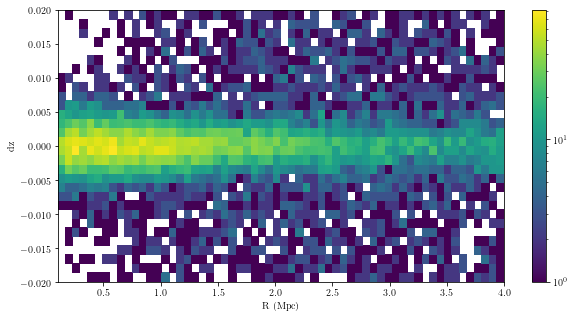

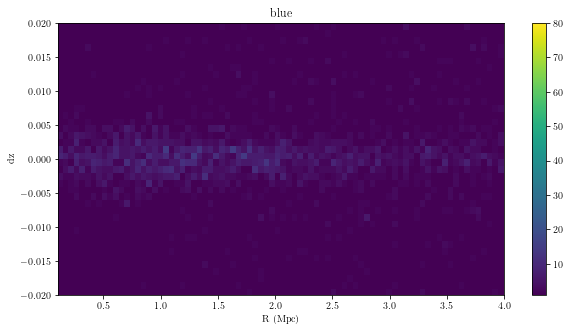

In [12]:
R = velocity[:,0]
dz = velocity[:,1]
Lambda = velocity[:,5]
z = velocity[:,6]
Mag_g = velocity[:,2]
Mag_r = velocity[:,3]
mean_lambda = np.mean(Lambda)
R_scale = R/(Lambda/mean_lambda)**(1./3)
mean_z = np.mean(z)

print('mean_lambda', mean_lambda)
print('mean_z', mean_z)
print('mean_mass', mass_richness_sv(mean_lambda, mean_z))

mask_r = (Mag_g-Mag_r)>np.percentile(Mag_g-Mag_r, 50)
R_r = R[mask_r]
dz_r = dz[mask_r]
Lambda_r =Lambda[mask_r]
z_r =z[mask_r]

mplot.figure(figsize=(10,5))
hist_r = mplot.hist2d(R_scale[mask_r], dz_r, bins=(60,30), range=((0.1,4),(-0.02,0.02)), norm=pl.colors.LogNorm()) #, cmap=cm.jet)
# mplot.clim(1,80)
mplot.colorbar()

mplot.xlabel('R (Mpc)')
mplot.ylabel('dz')
mplot.savefig('phasespace.png')
# mplot.title('red')

mask_b = (Mag_g-Mag_r)<np.percentile(Mag_g-Mag_r, 25)
R_b = R[mask_b]
dz_b = dz[mask_b]
Lambda_b =Lambda[mask_b]
z_b =z[mask_b]

mplot.figure(figsize=(10,5))
mplot.hist2d(R_scale[mask_b]*(1+z_b), dz_b, bins=(80,40), range=((0.1,4),(-0.02,0.02))) #, norm=pl.colors.LogNorm()) #, cmap=cm.jet)
mplot.clim(1,80)
mplot.colorbar()
mplot.xlabel('R (Mpc)')
mplot.ylabel('dz')
mplot.title('blue')

# print(hist_r)


(array([5800., 6655., 4245., 4258., 3374., 3185., 2669., 1919., 2115.,
        2071., 1373., 1746., 1224.,  993., 1140.,  803.,  850.,  703.,
         911.,  672.,  554., 1015.,  310.,  790.,  409.,  409.,  224.,
         217.,  147.,  456.,  135.,  205.,  170.,   99.,   59.,   37.,
          94.,  196.,  115.,  283.,   91.,   92.,    0.,    0.,   96.,
          96.,   23.,    0.,    0.,  225.]),
 array([20.00348473, 21.60159588, 23.19970703, 24.79781818, 26.39592934,
        27.99404049, 29.59215164, 31.19026279, 32.78837395, 34.3864851 ,
        35.98459625, 37.58270741, 39.18081856, 40.77892971, 42.37704086,
        43.97515202, 45.57326317, 47.17137432, 48.76948547, 50.36759663,
        51.96570778, 53.56381893, 55.16193008, 56.76004124, 58.35815239,
        59.95626354, 61.55437469, 63.15248585, 64.750597  , 66.34870815,
        67.94681931, 69.54493046, 71.14304161, 72.74115276, 74.33926392,
        75.93737507, 77.53548622, 79.13359737, 80.73170853, 82.32981968,
        83.92793

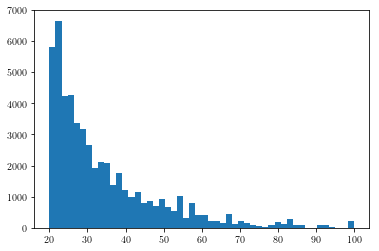

In [13]:
mplot.hist(Lambda, bins=50)

(array([ 876.,  948., 1109., 1019., 1072., 1885., 1224., 2119., 2100.,
         588.,  855.,  583., 1065., 1178., 1045., 1063., 1076., 1648.,
        1733., 1178.,  782., 1183., 1221., 1194.,  749.,  706., 1120.,
        1268.,  759.,  917.,  811., 1091., 1168., 1231.,  705., 1062.,
        1064.,  742., 1054.,  984., 1371.,  901., 1032.,  851.,  774.,
         767., 1037.,  793.,  697.,  855.]),
 array([0.10026205, 0.10225667, 0.1042513 , 0.10624593, 0.10824056,
        0.11023519, 0.11222982, 0.11422445, 0.11621908, 0.11821371,
        0.12020833, 0.12220296, 0.12419759, 0.12619222, 0.12818685,
        0.13018148, 0.13217611, 0.13417074, 0.13616537, 0.13816   ,
        0.14015462, 0.14214925, 0.14414388, 0.14613851, 0.14813314,
        0.15012777, 0.1521224 , 0.15411703, 0.15611166, 0.15810628,
        0.16010091, 0.16209554, 0.16409017, 0.1660848 , 0.16807943,
        0.17007406, 0.17206869, 0.17406332, 0.17605794, 0.17805257,
        0.1800472 , 0.18204183, 0.18403646, 0.18603109, 

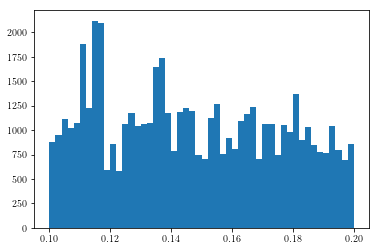

In [14]:
mplot.hist(z, bins=50)

0.002


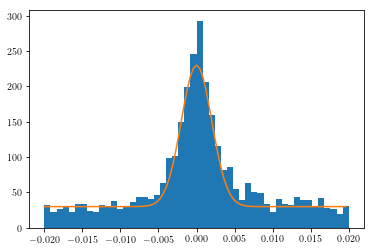

In [15]:
r_mask = (R_scale>=3)*(R_scale<4)
mplot.hist(dz[r_mask], range=(-0.02,0.02), bins=50)
ddz = np.arange(100)*0.0004-0.02
sigma = 0.002*(30./30)**0.5
print(sigma)
mplot.plot(ddz, 200*np.exp(-0.5*(ddz)**2/sigma**2) + 30)

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


['fun', 'hess_inv', 'jac', 'message', 'nfev', 'nit', 'status', 'success', 'x']
[-0.00654836 -0.0005457   0.00254659]
[0.00205386 0.05045789 0.47543293]
  2.0539e-03 ± 2.6e-04
  5.0458e-02 ± 1.2e-01
  4.7543e-01 ± 5.9e-02
Running sampler...
Done running sampler


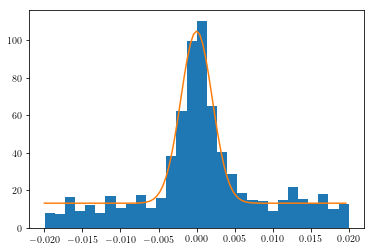

In [16]:
p0 = [0.001, 0.3, 0.1]
bounds = ((0.0001,0.1), (-1,1.5), (0.01,0.99))

def lnlikelihood(params, dz, lamb):
    """In one R bin, input data is delta z"""
    sigma0, alpha, p = params

    if p>1:
        lnlike_out = -1.0e10
    else:
        sigma  = sigma0* (lamb/30.0)**alpha
        like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*dz**2/sigma**2) + (1.-p)/0.04 #*(B*dz -0.02*B + 1./0.04 + 0.02*0.04)
        lnlike_out = np.sum(np.log(like))

#     print(lnlike_out)
    return lnlike_out

def lnprior(params):
    """In one R bin, input data is delta z"""
    sigma0, alpha, p = params
    if (sigma0<bounds[0][0]) or (sigma0>bounds[0][1]) or (alpha<bounds[1][0]) or (alpha>bounds[1][1]) or (p<bounds[2][0]) or (p>bounds[2][1]):
        lnprior = -1.0e10
    else:
        lnprior = 1000.
#     print(lnprior)
    return lnprior

def lnposterior(params, dz, lamb):

    lnpriors = lnprior(params)
    lnlike = lnlikelihood(params, dz, lamb)
    lnposterior = lnlike + lnpriors
#     print(lnlike, lnpriors,lnposterior)
    return lnposterior


nll = lambda *args: -lnlikelihood(*args)
method = 'L-BFGS-B'

r_mask = (R_r>=4)*(R_r<5)
args = (dz_r[r_mask], Lambda_r[r_mask])
result = op.minimize(nll, p0, args=args, method = method, options={'disp':True}, bounds = bounds)

mplot.hist(dz_r[r_mask], bins=30, normed=1)
sigma0, alpha, p = result.x
sigma  = sigma0* (np.mean(Lambda_r[r_mask])/30.0)**alpha
like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)/0.04
#*(B*ddz -0.02*B + 1./0.04 + 0.02*0.04) #/0.04
mplot.plot(ddz, like)

print(dir(result))
print(result.jac)
print(result.x)

ftol = 2.220446049250313e-09
tmp_i = np.zeros(len(result.x))
for i in range(3):
    tmp_i[i] = 1.0
    uncertainty_i = np.sqrt(max(1, abs(result.fun))*ftol*result.hess_inv(tmp_i)[i])
    tmp_i[i] = 0.0
    print('{0:12.4e} ± {1:.1e}'.format(result.x[i], uncertainty_i))
    
# MCMC
nwalkers = 128
start_p0 = result.x
ndim = len(start_p0)

#Set up initial positions
p0_walkers = [np.random.randn(ndim)*0.01 + start_p0 for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=args)

print("Running sampler...")
num_samps = 100
sampler.run_mcmc(p0_walkers, num_samps)

print("Done running sampler")
chain = sampler.flatchain
lnlike = sampler.flatlnprobability


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[0.00254595 0.21205971 0.98951977]
Running sampler...
Done running sampler
[0.00266228 0.58767871 0.97443914]
Running sampler...
Done running sampler
[0.00268816 0.16322635 0.96131505]
Running sampler...
Done running sampler
[0.00225747 0.64100871 0.94928793]
Running sampler...
Done running sampler
[0.00242355 0.32166414 0.96014171]
Running sampler...
Done running sampler
[0.00261795 0.44021562 0.95774404]
Running sampler...
Done running sampler
[0.00261433 0.39479267 0.93065861]
Running sampler...
Done running sampler
[0.00224912 0.44935901 0.8977339 ]
Running sampler...
Done running sampler
[0.00238853 0.54571311 0.91953964]
Running sampler...
Done running sampler
[0.00253234 0.46790583 0.92906942]
Running sampler...
Done running sampler
[0.00262961 0.34502177 0.91329972]
Running sampler...
Done running sampler
[0.00238963 0.32412856 0.86709472]
Running sampler...
Done running sampler
[0.00215401 0.50339537 0.8314723 ]
Running sampler...
Done running sampler
[0.00205764 0.45093218 0.

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Done running sampler
[0.00202408 0.19959674 0.42233231]
Running sampler...
Done running sampler
[0.00211645 0.01148194 0.40582105]
Running sampler...
Done running sampler
[0.00174271 0.64790639 0.36114104]
Running sampler...
Done running sampler


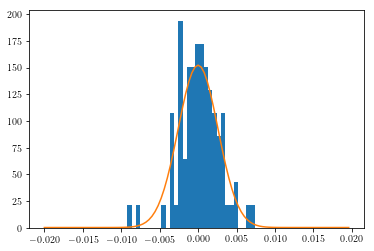

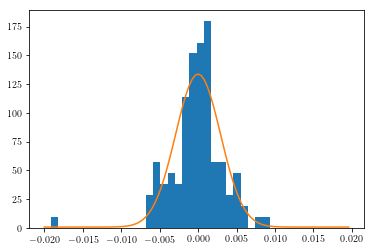

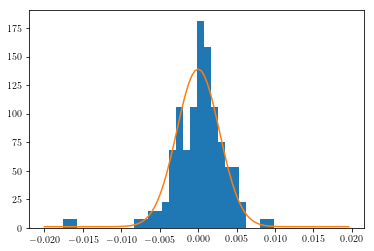

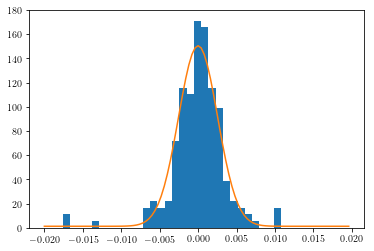

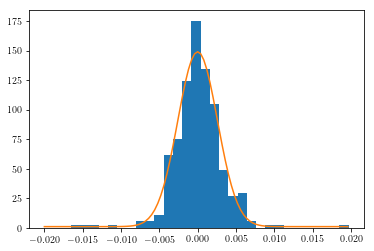

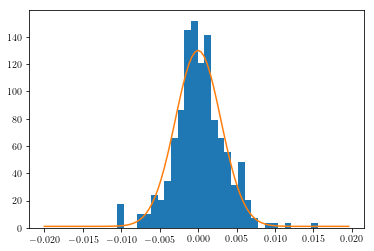

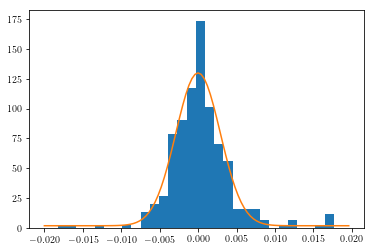

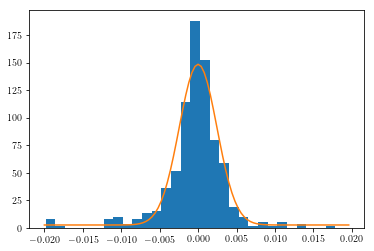

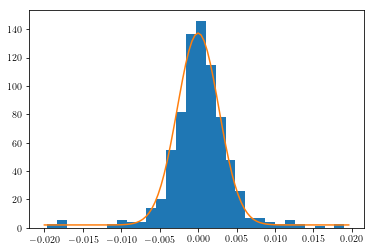

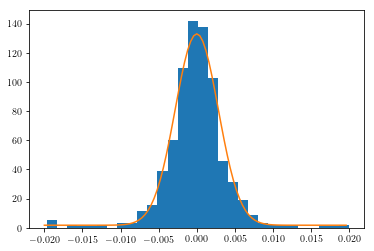

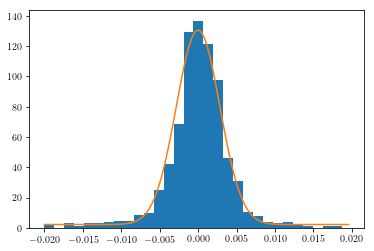

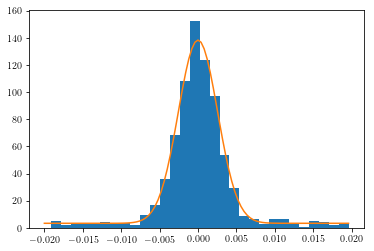

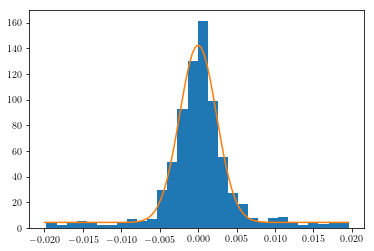

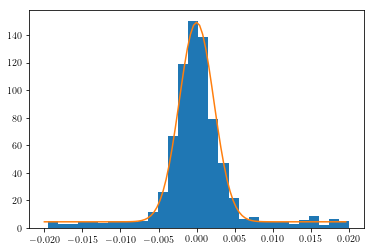

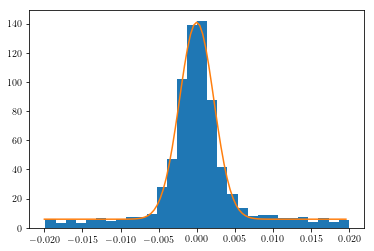

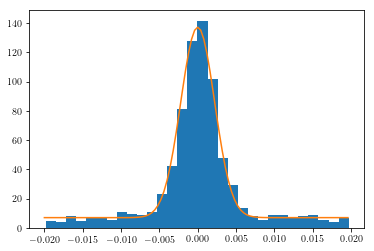

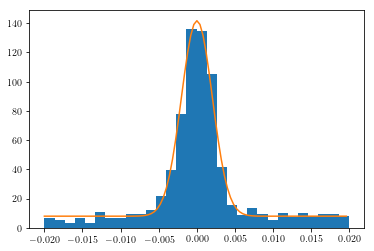

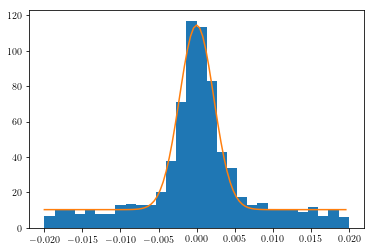

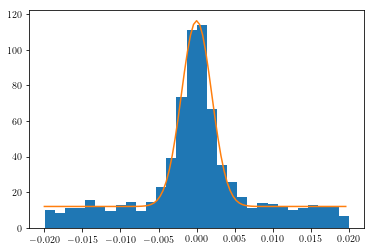

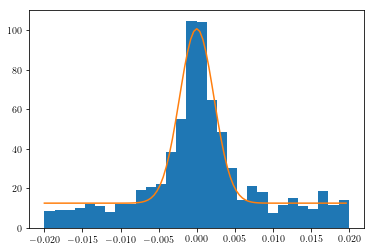

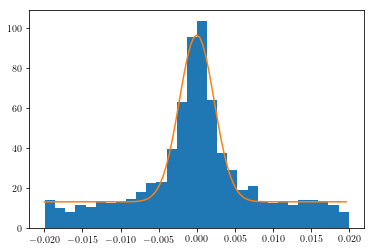

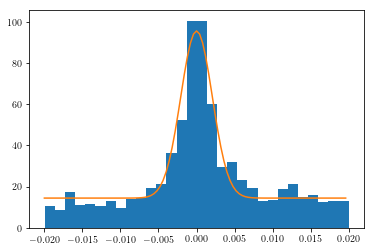

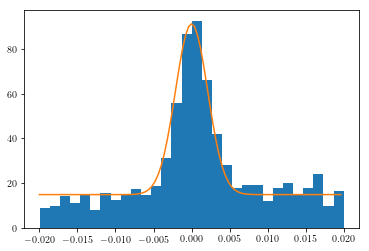

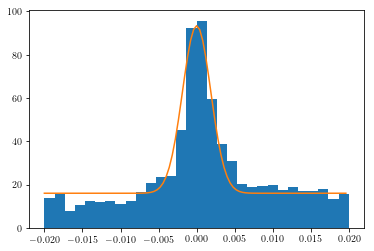

In [122]:
# ftol = 1e-8

bin_edge = np.logspace(np.log10(0.1), np.log10(6), num=25)
bin_min = bin_edge[:-1]
bin_max = bin_edge[1:]
bin_mid = (bin_min*bin_max)**0.5

Results = []
Chain = []
Sigma = []
for i in range(24):
    r_mask = (R>=bin_min[i])*(R<bin_max[i])
#     print(len(dz[r_mask]))
    args = (dz[r_mask], Lambda[r_mask])
    result = op.minimize(nll, p0, args=args, method = method, options={'ftol':1e-8, 'disp':True}, bounds = bounds)

    mplot.figure()
    mplot.hist(dz[r_mask], bins=30, normed=1)
    sigma0, alpha, p = result.x
    print(result.x)
    sigma  = sigma0* (np.mean(Lambda[r_mask])/30.0)**alpha
    like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)/0.04 #*(B*ddz -0.02*B + 1./0.04)
    mplot.plot(ddz, like)
    Results.append(result.x)
    
#     tmp_j = np.zeros(len(result.x))
#     err = []
#     for j in range(3):
#         tmp_j[j] = 1.0
#         uncertainty_j = np.sqrt(max(1, abs(result.fun))*ftol*result.hess_inv(tmp_j)[j])
#         tmp_j[j] = 0.0
#         err.append(uncertainty_j)
#     err = np.array(err)
#     Err.append(err)


    # MCMC
    nwalkers = 256
    start_p0 = result.x
    ndim = len(start_p0)
    r1 = np.min((np.abs(bounds[0][0] - start_p0[0]), np.abs(bounds[0][1] - start_p0[0])))
    r2 = np.min((np.abs(bounds[1][0] - start_p0[1]), np.abs(bounds[1][1] - start_p0[1])))
    r3 = np.min((np.abs(bounds[2][0] - start_p0[2]), np.abs(bounds[2][1] - start_p0[2])))

    #Set up initial positions
    p0_walkers = [np.random.rand(ndim)*np.array([r1,r2,r3])*0.1 + start_p0 for j in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=args)

    print("Running sampler...")
    num_samps = 100
    sampler.run_mcmc(p0_walkers, num_samps)

    print("Done running sampler")
    chain = sampler.flatchain
    lnlike = sampler.flatlnprobability
    Chain.append(chain)
    Sigma.append(sigma)

Results = np.array(Results)
Chain = np.array(Chain)
Sigma = np.array(Sigma)

In [447]:
# help(sampler.run_mcmc)

In [448]:
# mplot.figure(figsize=(5,15))

# mplot.subplot(311)
# mplot.errorbar(bin_mid, Results[:,0])
# mplot.ylim(0.001,0.003)
# mplot.ylabel('$\\sigma_{0}$')
# mplot.xlabel('$R_{scale}$ (Mpc)')

# mplot.subplot(312)
# mplot.errorbar(bin_mid, Results[:,1])
# mplot.ylim(0.0,0.8)
# mplot.ylabel('$\\alpha$')
# mplot.xlabel('$R_{scale}$ (Mpc)')

# mplot.subplot(313)
# mplot.errorbar(bin_mid, Results[:,2])
# mplot.ylim(0.3,1.0)
# mplot.ylabel('$p$')
# mplot.xlabel('$R_{scale}$ (Mpc)')

# mplot.tight_layout()

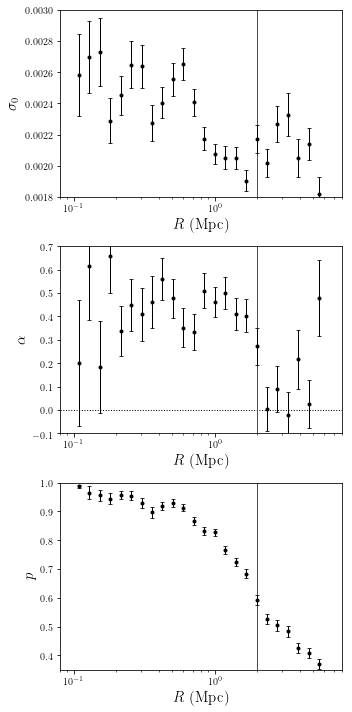

In [134]:
mean = []
err = []
for i in range(24):
    mean.append(np.mean(Chain[i], axis=0))
    err.append(np.std(Chain[i], axis=0))

mean = np.array(mean)
err = np.array(err)

mplot.figure(figsize=(5,10))

mplot.subplot(311)
mplot.errorbar(bin_mid, mean[:,0], yerr=err[:,0],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.ylim(0.0018,0.003)
mplot.xlim(0.08,8)
mplot.plot([2,2], [0.0018,0.003], ls='-', color='r',lw=1)
# mplot.plot([0.8,0.8], [0.0018,0.003], ls='-', color='grey',lw=1)
mplot.ylabel('$\\sigma_{0}$', fontsize=15)
mplot.xscale('log')
# mplot.yscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.subplot(312)
mplot.errorbar(bin_mid, mean[:,1], yerr=err[:,1],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.ylim(-0.1,0.7)
mplot.xlim(0.08,8)
mplot.plot([0.05,8], [0.0,0.0], ls=':', color='k',lw=1)
mplot.plot([2,2], [-0.1,0.7], ls='-', color='r',lw=1)
# mplot.plot([0.8,0.8], [-0.1,0.7], ls='-', color='grey',lw=1)
mplot.ylabel('$\\alpha$', fontsize=15)
mplot.xscale('log')
# mplot.yscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.subplot(313)
mplot.errorbar(bin_mid, mean[:,2], yerr=err[:,2],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.ylim(0.35,1.0)
mplot.xlim(0.08,8)
mplot.plot([2,2], [0.35,1.0], ls='-', color='r',lw=1)
# mplot.plot([0.8,0.8], [0.35,1.0], ls='-', color='grey',lw=1)
mplot.ylabel('$p$', fontsize=15)
mplot.xscale('log')
# mplot.yscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.tight_layout()    
mplot.savefig('phasespace_fit.png')

Text(0.5, 0, '$R$ (Mpc)')

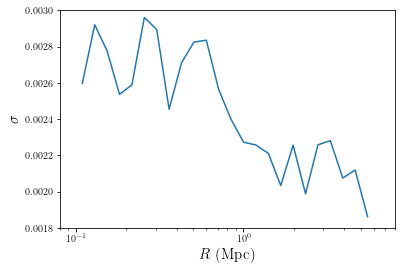

In [79]:
mplot.plot(bin_mid, Sigma)
mplot.ylim(0.0018,0.003)
mplot.xlim(0.08,8)
mplot.ylabel('$\\sigma$', fontsize=15)
mplot.xscale('log')
# mplot.yscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)


25600


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.00181599, 0.00182702, 0.00183804, 0.00184907, 0.00186009,
        0.00187112, 0.00188214, 0.00189317, 0.0019042 , 0.00191522,
        0.00192625, 0.00193727, 0.0019483 , 0.00195932, 0.00197035,
        0.00198138, 0.0019924 , 0.00200343, 0.00201445, 0.00202548,
        0.0020365 , 0.00204753, 0.00205856, 0.00206958, 0.00208061,
        0.00209163, 0.00210266, 0.00211368, 0.00212471, 0.00213574,
        0.00214676, 0.00215779, 0.00216881, 0.00217984, 0.00219086,
        0.00220189, 0.00221292, 0.00222394, 0.00223497, 0.00224599,
        0.00225702, 0.00226804, 0.00227907, 0.0022901 , 0.00230112,
        0.00231215, 0.00232317, 0.0023342 , 0.00234522, 0.00235625,
        0.00236728, 0.0023783 , 0.00238933, 0.00240035, 0.00241138,
   

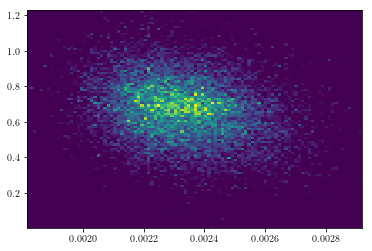

In [384]:
print(len(Chain[3][:,0]))
mplot.hist2d(Chain[3][:,0], Chain[3][:,1], bins=100)

In [344]:
# like2 = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)*100

In [17]:
bin_edge = np.logspace(np.log10(0.1), np.log10(6), num=11)
bin_min = bin_edge[:-1]
bin_max = bin_edge[1:]
bin_mid = (bin_min*bin_max)**0.5


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[0.00270369 0.27238715 0.99      ]
Running sampler...
Done running sampler
[0.00234373 0.44548401 0.96358592]
Running sampler...
Done running sampler
[0.00241315 0.46783515 0.95431766]
Running sampler...
Done running sampler
[0.00234502 0.54070312 0.93072624]
Running sampler...
Done running sampler
[0.00223019 0.45448657 0.91217283]
Running sampler...
Done running sampler
[0.00199566 0.46139266 0.84972591]
Running sampler...
Done running sampler
[0.0019399  0.4336555  0.76899139]
Running sampler...
Done running sampler
[0.00203398 0.13678665 0.59801163]
Running sampler...
Done running sampler
[0.00226211 0.04309588 0.49915309]
Running sampler...
Done running sampler
[0.00209898 0.08850664 0.45260019]
Running sampler...
Done running sampler


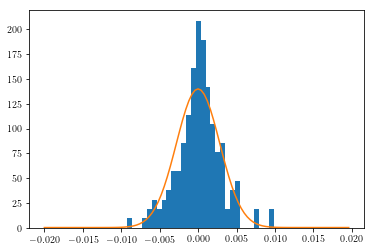

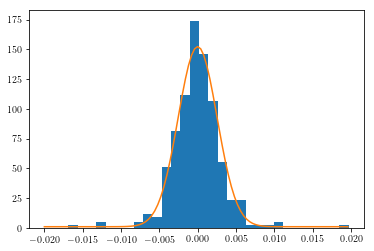

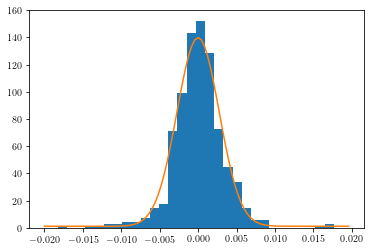

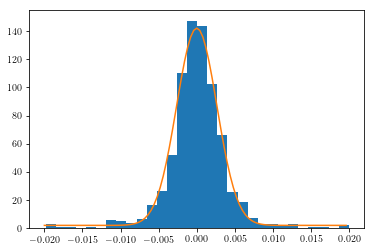

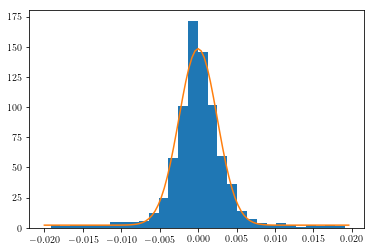

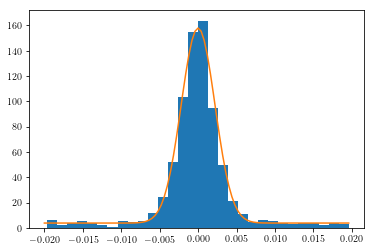

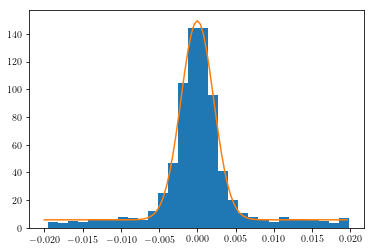

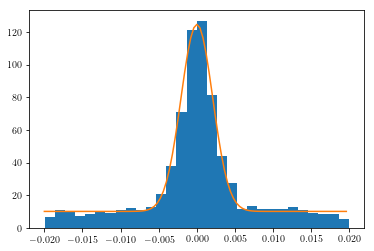

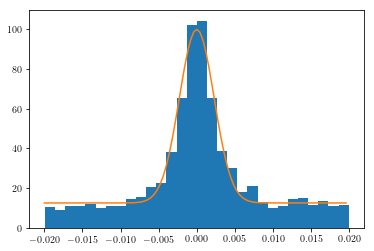

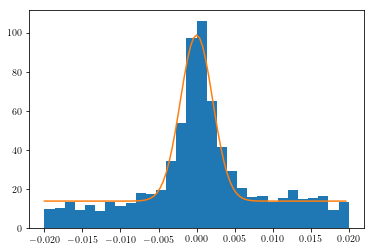

In [18]:
### RED

Results = []
Chain = []
Sigma = []
for i in range(10):
    r_mask = (R_r>=bin_min[i])*(R_r<bin_max[i])
    args = (dz_r[r_mask], Lambda_r[r_mask])
    result = op.minimize(nll, p0, args=args, method = method, options={'ftol':1e-8, 'disp':True}, bounds = bounds)

    mplot.figure()
    mplot.hist(dz_r[r_mask], bins=30, normed=1)
    sigma0, alpha, p = result.x
    print(result.x)
    sigma  = sigma0* (np.mean(Lambda_r[r_mask])/30.0)**alpha
    like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)/0.04 #*(B*ddz -0.02*B + 1./0.04)
    mplot.plot(ddz, like)
    Results.append(result.x)
    
    # MCMC
    nwalkers = 256
    start_p0 = result.x
    ndim = len(start_p0)
    r1 = np.min((np.abs(bounds[0][0] - start_p0[0]), np.abs(bounds[0][1] - start_p0[0])))
    r2 = np.min((np.abs(bounds[1][0] - start_p0[1]), np.abs(bounds[1][1] - start_p0[1])))
    r3 = np.min((np.abs(bounds[2][0] - start_p0[2]), np.abs(bounds[2][1] - start_p0[2])))

    #Set up initial positions
    p0_walkers = [np.random.rand(ndim)*np.array([r1,r2,r3])*0.1 + start_p0 for j in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=args)

    print("Running sampler...")
    num_samps = 100
    sampler.run_mcmc(p0_walkers, num_samps)

    print("Done running sampler")
    chain = sampler.flatchain
    lnlike = sampler.flatlnprobability
    Chain.append(chain)
    Sigma.append(sigma)

Results = np.array(Results)
Chain = np.array(Chain)
Sigma = np.array(Sigma)

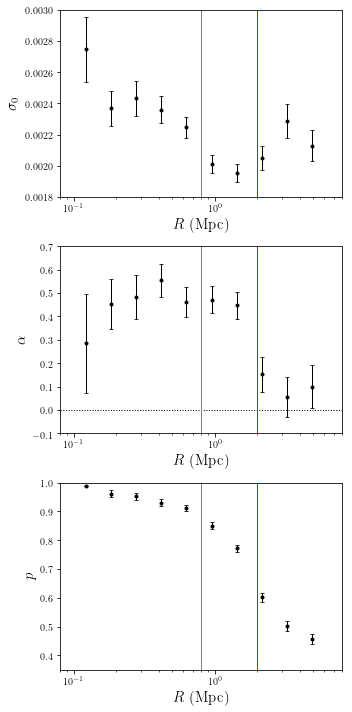

In [19]:
mean = []
err = []
for i in range(10):
    mean.append(np.mean(Chain[i], axis=0))
    err.append(np.std(Chain[i], axis=0))

mean = np.array(mean)
err = np.array(err)

mplot.figure(figsize=(5,10))

mplot.subplot(311)
mplot.errorbar(bin_mid, mean[:,0], yerr=err[:,0],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.ylim(0.0018,0.003)
mplot.xlim(0.08,8)
mplot.plot([2,2], [0.0018,0.003], ls='-', color='r',lw=1)
mplot.plot([0.8,0.8], [0.0018,0.003], ls='-', color='grey',lw=1)
mplot.ylabel('$\\sigma_{0}$', fontsize=15)
mplot.xscale('log')
# mplot.yscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.subplot(312)
mplot.errorbar(bin_mid, mean[:,1], yerr=err[:,1],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.ylim(-0.1,0.7)
mplot.xlim(0.08,8)
mplot.plot([0.05,8], [0.0,0.0], ls=':', color='k',lw=1)
mplot.plot([2,2], [-0.1,0.7], ls='-', color='r',lw=1)
mplot.plot([0.8,0.8], [-0.1,0.7], ls='-', color='grey',lw=1)
mplot.ylabel('$\\alpha$', fontsize=15)
mplot.xscale('log')
# mplot.yscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.subplot(313)
mplot.errorbar(bin_mid, mean[:,2], yerr=err[:,2],c='k', lw=1, marker='.', fmt='.', capthick=0.8, capsize=2.2, zorder=3)
mplot.ylim(0.35,1.0)
mplot.xlim(0.08,8)
mplot.plot([2,2], [0.35,1.0], ls='-', color='r',lw=1)
mplot.plot([0.8,0.8], [0.35,1.0], ls='-', color='grey',lw=1)
mplot.ylabel('$p$', fontsize=15)
mplot.xscale('log')
# mplot.yscale('log')
mplot.xlabel('$R$ (Mpc)', fontsize=15)

mplot.tight_layout()    

In [345]:
# first run maxlike then run mcmc

#Set up initial positions
p0_walkers = [np.random.randn(ndim)*0.05 + start_p0 for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args = args)

print "Running sampler..."
num_samps = 500
sampler.run_mcmc(p0_walkers, num_samps)
print "Done running sampler"
chain = sampler.flatchain
lnlike = sampler.flatlnprobability


SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Running sampler...")? (<ipython-input-345-00cfde14b33e>, line 7)

In [ ]:
p0 = [0.001, 1.0, 0.8]
bounds = ((0.0001,0.1), (0.1,1.5), (0.01,0.9))
r_mask = (R_scale>=4)*(R_scale<5)
args = (dz[r_mask], Lambda[r_mask])

nwalkers = 128
start_p0 = result.x
ndim = len(start_p0)

#Set up initial positions
p0_walkers = [np.random.randn(ndim)*0.05 + start_p0 for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior_sigma, args = args)



result = op.minimize(nll, p0, args=args, method = method, options={'disp':True}, bounds = bounds)


mplot.hist(dz[r_mask], bins=30, normed=1)
sigma0, alpha, p = result.x
sigma  = sigma0* (np.mean(Lambda[r_mask])/30.0)**alpha
like = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)/0.04
#*(B*ddz -0.02*B + 1./0.04 + 0.02*0.04) #/0.04
mplot.plot(ddz, like)

print(dir(result))
print(result.jac)
print(result.x)

#int ax  + b = 1
#0.04* a/2 + b = 1
#b = -0.02a

#B 0.04*0.02 - 0.02*0.04 - 0.02 B 0.04

# sigma = 0.003
# like2 = p*(2*np.pi*sigma**2)**(-0.5)*np.exp(-0.5*ddz**2/sigma**2) + (1.-p)*300
# mplot.plot(ddz, like2*5)

#(10,300), (10,50), 


# res = op.least_squares(nll, p0, bounds=(0, 100), args=args, verbose=1)
#print(result.x)
# print(lnlike(p0, dz[r_mask], Lambda[r_mask]))
# params = [A, B, C, sigma0, lamb0, alpha]

ftol = 2.220446049250313e-09
tmp_i = np.zeros(len(result.x))
for i in range(3):
    tmp_i[i] = 1.0
    uncertainty_i = np.sqrt(max(1, abs(result.fun))*ftol*result.hess_inv(tmp_i)[i])
    tmp_i[i] = 0.0
    print('{0:12.4e} ± {1:.1e}'.format(result.x[i], uncertainty_i))

In [ ]:
# def model(dz, lamb, A, B, C, sigma0, lamb0, alpha):
#     """model for each R bin"""

#     sigma0 = (lamb/lamb0)**alpha
#     return A*np.exp(-0.5*(C*dz)**2/sigma**2) + B

#     mod = model(dz, lamb, A, B, C, sigma0, lamb0, alpha)
#     diff = data_vec - model
#     detinvcov = np.linalg.det(invcov)
#     detcov = 1./detinvcov
#     lnlike = -0.5*(len(data_vec)*np.log(2.*np.pi) + np.log(detcov)) -0.5*np.dot(diff, np.dot(invcov, diff))


In [ ]:
#TODO:
# need redshift
# 